# 時序差分之SARSA演算法_GridWorld網格世界

In [1]:
# 匯入zipfile模組，用來處理.zip壓縮檔案
import zipfile

# 使用with敘述開啟lib.zip壓縮檔案，確保使用完自動關閉
with zipfile.ZipFile("lib.zip") as zf:
    # 使用infolist()取得壓縮檔中所有檔案的資訊(ZipInfo物件)
    for info in zf.infolist():
    
        # 因為某些zip壓縮檔的檔名是以cp437編碼(特別是從Windows系統壓縮的)
        # 所以這裡先將原本的檔名(字串)用cp437編碼為bytes，再用utf-8解碼為正確的字串
        # 這樣可以正確顯示中文或特殊字元的檔名
        print(info.filename.encode('cp437').decode('utf-8'))

        # 將目前這個檔案(info)解壓縮到target_folder資料夾中
        zf.extract(info, "target_folder")

lib/__init__.py
lib/__pycache__/
lib/__pycache__/__init__.cpython-38.pyc
lib/__pycache__/__init__.cpython-39.pyc
lib/__pycache__/plotting.cpython-38.pyc
lib/__pycache__/plotting.cpython-39.pyc
lib/atari/
lib/atari/__init__.py
lib/atari/helpers.py
lib/atari/state_processor.py
lib/envs/
lib/envs/.ipynb_checkpoints/
lib/envs/.ipynb_checkpoints/gridworld-checkpoint.py
lib/envs/__init__.py
lib/envs/__pycache__/
lib/envs/__pycache__/__init__.cpython-36.pyc
lib/envs/__pycache__/__init__.cpython-38.pyc
lib/envs/__pycache__/__init__.cpython-39.pyc
lib/envs/__pycache__/blackjack.cpython-38.pyc
lib/envs/__pycache__/blackjack.cpython-39.pyc
lib/envs/__pycache__/cliff_walking.cpython-36.pyc
lib/envs/__pycache__/cliff_walking.cpython-38.pyc
lib/envs/__pycache__/cliff_walking.cpython-39.pyc
lib/envs/__pycache__/discrete.cpython-38.pyc
lib/envs/__pycache__/discrete.cpython-39.pyc
lib/envs/__pycache__/gridworld.cpython-38.pyc
lib/envs/__pycache__/gridworld.cpython-39.pyc
lib/envs/__pycache__/gridworld0

In [2]:
# 匯入itertools模組，用於高效迭代工具
import itertools

# 匯入matplotlib套件，用於資料視覺化
import matplotlib

# 匯入numpy套件，用於數值計算與陣列處理
import numpy as np

# 匯入pandas套件，用於資料操作與分析
import pandas as pd

# 匯入sys模組，用於與系統互動
import sys

# 匯入os模組，用於與作業系統互動
import os

# 將指定路徑加入系統模組搜尋路徑中，這樣可以匯入該路徑下的自訂模組
sys.path.append(os.path.abspath("E:/Colab第三階段202505/ch21_20250828/reinforcement-learning"))

# 從collections模組匯入defaultdict，用於建立帶有預設值的字典
from collections import defaultdict

# 從lib.envs.gridworld模組匯入GridworldEnv類別
# 這代表有一個自定義的「網格世界」強化學習環境，位於專案的lib/envs/gridworld.py檔案中
from lib.envs.gridworld import GridworldEnv

# 從lib.agents.td_agent模組匯入TDAgent類別，這是一個時間差分學習代理
from lib import plotting

# 設定matplotlib的繪圖風格為ggplot
matplotlib.style.use('ggplot')

Gym has been unmaintained since 2022 and does not support NumPy 2.0 amongst other critical functionality.
Please upgrade to Gymnasium, the maintained drop-in replacement of Gym, or contact the authors of your software and request that they upgrade.
See the migration guide at https://gymnasium.farama.org/introduction/migration_guide/ for additional information.


In [3]:
# 建立一個GridWorld強化學習環境實例
env = GridworldEnv()

In [4]:
# 印出一段說明文字，描述環境轉移字典env.P的結構格式
# env.P的結構如下：
# {狀態: {行動: [(轉移機率, 下一個狀態, 獎勵, 是否到達終點), ... ]}}

print('''{狀態: {行動: [(轉移機率, 下一個狀態, 獎勵, 是否到達終點),
      (轉移機率, 下一個狀態, 獎勵, 是否到達終點)]}}''')

{狀態: {行動: [(轉移機率, 下一個狀態, 獎勵, 是否到達終點),
      (轉移機率, 下一個狀態, 獎勵, 是否到達終點)]}}


In [5]:
# 定義ε-貪婪策略函數，用於根據給定的Q函數與ε值，產生一個行為策略函數
# Q：是一個狀態-行動價值函數(dict或array)，Q[s][a]表示在狀態s採取動作a的期望報酬
# epsilon：探索率，決定非最佳動作的選擇機率
# nA：每個狀態下的動作總數(例如：上下左右為4)

def make_epsilon_greedy_policy(Q, epsilon, nA):
    # 傳回一個策略函數：輸入狀態(observation)，輸出每個動作的機率分布
    def policy_fn(observation):
        # 初始化一個長度為nA的陣列，所有動作機率設為ε / nA(均分探索機率)
        A = np.ones(nA, dtype = float) * (epsilon / nA)

        # 找出在當前觀察狀態下，Q值最高的動作(最佳動作)
        best_action = np.argmax(Q[observation])

        # 將最佳動作的機率加上1 - ε，使其總機率為1 - ε + (ε / nA)
        A[best_action] += (1.0 - epsilon)

        # 傳回這個動作機率分布(是一個ndarray多維陣列)
        return A

    # 傳回產生的策略函數(可以用於選擇行動)
    return policy_fn

In [6]:
# 定義SARSA策略學習函式
# env：環境物件
# num_episodes：執行的回合數(預設100)
# discount_factor：折扣因子γ，控制未來獎勵重要性(預設1.0)
# alpha：學習率，控制Q值更新幅度(預設0.5)
# epsilon：ε-greedy策略中探索的機率(預設0.01)

def sarsa(env, num_episodes, discount_factor = 1.0, alpha = 0.5, epsilon = 0.01):
    # 初始化行動值函數Q，預設每個狀態的動作值為0(動作數為環境的動作空間大小)
    Q = defaultdict(lambda: np.zeros(env.action_space.n))

    # 建立統計資料物件，用來紀錄每回合的長度與總獎勵
    stats = plotting.EpisodeStats(
        episode_lengths = np.zeros(num_episodes),  # 每回合執行的步數
        episode_rewards = np.zeros(num_episodes))  # 每回合獲得的總獎勵

    # 建立ε-greedy策略，根據當前Q值與探索率epsilon產生行動機率分布
    policy = make_epsilon_greedy_policy(Q, epsilon, env.action_space.n)

    # 進行指定數量的回合(num_episodes)
    for i_episode in range(num_episodes):
        # 每100回合輸出進度提示
        if (i_episode + 1) % 100 == 0:
            print(f"\r {(i_episode + 1)}/{num_episodes} 回合.", end="")
            sys.stdout.flush()  # 清除緩衝區，即時輸出

        # 重設環境並取得初始狀態
        state = env.reset()

        # 取得當前狀態下的行動機率分布
        action_probs = policy(state)

        # 按機率抽樣動作
        action = np.random.choice(np.arange(len(action_probs)), p = action_probs)

        # 無限迴圈直到環境終止
        for t in itertools.count():

            # 執行選定的動作，取得新狀態與獎勵
            next_state, reward, done, _ = env.step(action)

            # 根據新狀態再次使用ε-greedy策略選擇下一個動作
            next_action_probs = policy(next_state)
            next_action = np.random.choice(np.arange(len(next_action_probs)), p = next_action_probs)

            # 累加統計資訊：目前回合的總獎勵與步數
            stats.episode_rewards[i_episode] += reward
            stats.episode_lengths[i_episode] = t

            # 使用SARSA更新Q值(時間差分TD更新)
            td_target = reward + discount_factor * Q[next_state][next_action]  # 預期回報
            td_delta = td_target - Q[state][action]                            # TD誤差
            Q[state][action] += alpha * td_delta                               # Q值更新

            # 若回合結束(抵達終點或失敗)，則結束此次回合
            if done:
                break

            # 否則準備進入下一個時間步
            action = next_action
            state = next_state

    # 傳回最終學習到的Q值與統計資訊
    return Q, stats

In [7]:
%%time

# 執行SARSA策略學習函式，訓練500個回合
# 傳回的Q是學到的狀態-動作價值函數
# stats紀錄每回合的長度和獎勵資訊

Q, stats = sarsa(env, 500)

 500/500 回合.CPU times: total: 125 ms
Wall time: 124 ms


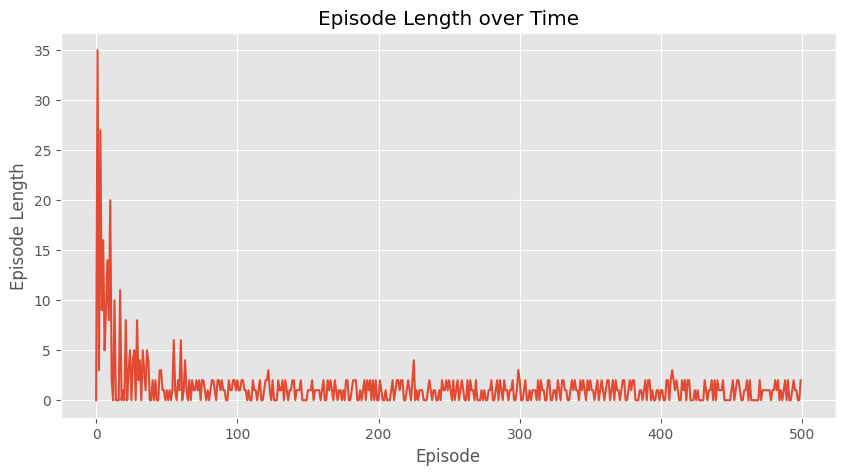

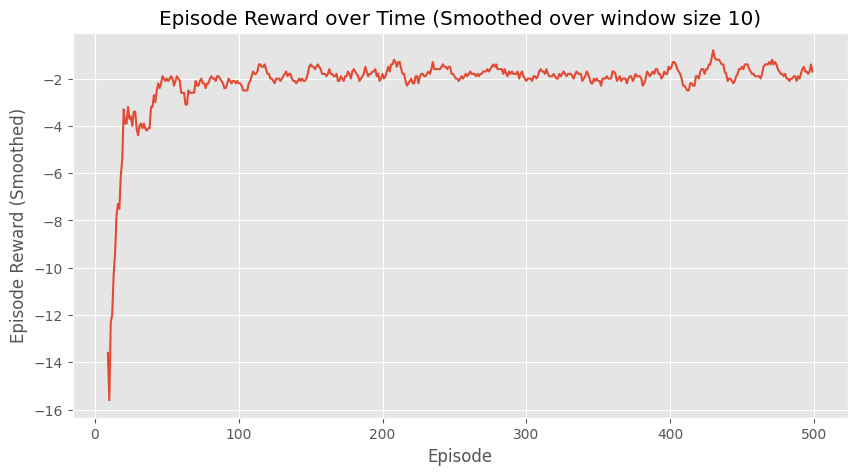

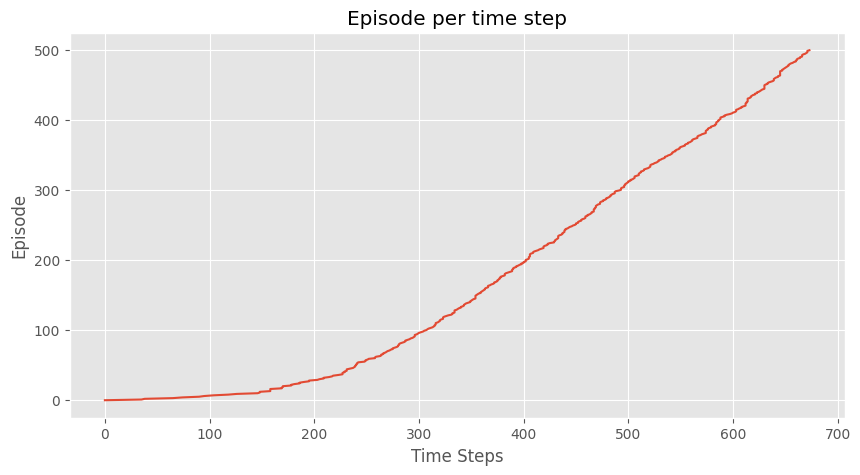

In [8]:
# 顯示訓練結果的圖表(每回合的累積獎勵與長度變化)
# stats是從SARSA函式中傳回的紀錄物件，包含訓練過程中的統計數據
# plot_episode_stats是一個繪圖工具函式，會產生三個圖：

# 1.每回合的累積獎勵(Episode Rewards over Time)
# 2.每回合的步數(Episode Length over Time)
# 3.平均100回合的獎勵趨勢(Moving Average of Rewards)

fig = plotting.plot_episode_stats(stats)